<a href="https://colab.research.google.com/github/CamiloVga/Curso-Inteligencia-Artificial/blob/main/Clase_FineTuning_TextGen_BaseStream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install peft

In [2]:
# Importar las librerías necesarias
!pip install -U bitsandbytes accelerate transformers
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import random
import matplotlib.pyplot as plt
from transformers import TrainerCallback

# Cargar el dataset con streaming y tomar 100 ejemplos aleatorios
dataset = load_dataset("othorizedshogun/poems_dataset", split="train", streaming=True)
dataset = dataset.shuffle(seed=42).take(100)

# Cargar el modelo y el tokenizador
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Función para preprocesar el dataset
def preprocess_function(example):
    text = f"<s>[INST] {example['input']} [/INST] {example['poem']} </s>"
    return tokenizer(text, truncation=True, padding="max_length", max_length=512)

# Aplicar el preprocesamiento
tokenized_dataset = dataset.map(preprocess_function)




Unused kwargs: ['bnb_8bit_use_double_quant', 'bnb_8bit_quant_type', 'bnb_8bit_compute_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

max_steps is given, it will override any value given in num_train_epochs
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning:

Step,Training Loss
5,2.343600
10,2.363300
15,2.191600
20,2.083900
25,1.975800


Step: 5, Loss: 2.3436
Step: 10, Loss: 2.3633
Step: 15, Loss: 2.1916
Step: 20, Loss: 2.0839
Step: 25, Loss: 1.9758


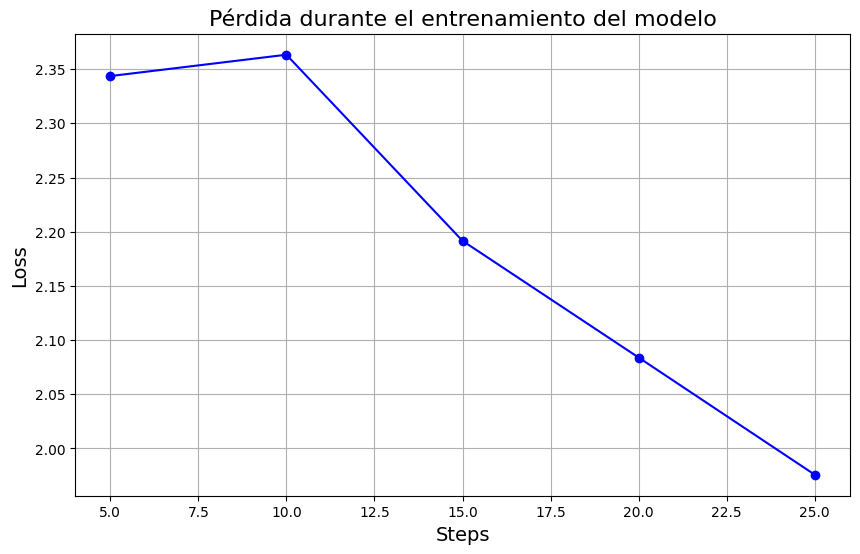

In [3]:
# Configurar BitsAndBytesConfig para cuantización de 8 bits
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf4",
    bnb_8bit_compute_dtype=torch.float16
)

# Configurar el modelo para entrenamiento de 8-bit
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
model = prepare_model_for_kbit_training(model)

# Configurar LoRA
# Configuración de LoRA (Low-Rank Adaptation)
peft_config = LoraConfig(
    r=16,  # Número de dimensiones latentes en LoRA
    lora_alpha=32,  # Multiplicador para escalar las actualizaciones LoRA
    lora_dropout=0.05,  # Probabilidad de dropout para LoRA
    bias="none",  # No ajustar el bias
    task_type="CAUSAL_LM"  # Tipo de tarea: modelo de lenguaje causal
)

model = get_peft_model(model, peft_config)

# Crear el callback para registrar las pérdidas
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            print(f"Step: {state.global_step}, Loss: {logs['loss']}")  # Depuración
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

# Instanciar el callback
loss_callback = LossCallback()

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",  # Carpeta de salida
    num_train_epochs=3,  # Número de épocas de entrenamiento
    per_device_train_batch_size=4,  # Tamaño del batch por dispositivo
    gradient_accumulation_steps=4,  # Acumular gradientes para 4 pasos
    warmup_steps=50,  # Número de pasos de warmup
    learning_rate=5e-4,  # Tasa de aprendizaje
    fp16=True,  # Usar media precisión (16 bits)
    logging_steps=5,  # Registrar cada 5 pasos
    save_steps=50,  # Guardar el modelo cada 50 pasos
    max_steps=25  # Número máximo de pasos de entrenamiento
)

# Preparar el data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Inicializar el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    callbacks=[loss_callback]  # Agregar el callback para registrar las pérdidas
)

# Entrenar el modelo
trainer.train()

# Guardar el modelo
trainer.save_model("./fine_tuned_phi2_poems")

# Graficar la función de pérdida después del entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(loss_callback.steps, loss_callback.losses, marker='o', linestyle='-', color='b')
plt.title('Pérdida durante el entrenamiento del modelo', fontsize=16)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Cargar el modelo entrenado
model = AutoModelForCausalLM.from_pretrained("./fine_tuned_phi2_poems")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Configurar el prompt para generar el poema
prompt = "<s>[INST] Escribe un poema sobre la luna [/INST]"

# Tokenizar el prompt
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generar el poema
output = model.generate(
    inputs['input_ids'],
    max_length=100,  # Máximo número de tokens generados
    num_return_sequences=1,  # Número de secuencias generadas
    temperature=0.7,  # Diversidad en la generación (más alto = más aleatorio)
    top_p=0.9,  # Nucleus sampling
    top_k=50  # Limitar a las top 50 opciones
)

# Decodificar el texto generado
generated_poem = tokenizer.decode(output[0], skip_special_tokens=True)

# Imprimir el poema generado
print(generated_poem)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]